In [ ]:
################
##Figure S2A####
################

In [76]:

#create dicionary of sequence, transcriptname(?), mutations in the area. use regex for CIGAR string info
from collections import defaultdict
import pandas as pd

def readinSAM (fileName):
    SAMfilePATH = './%s'%fileName
    cigarDic = defaultdict(str)
    seqDic = defaultdict(str)
    mapDic = defaultdict(int)
    with open(SAMfilePATH) as inpfile: #open samfile like text file   
        for line in inpfile: #reading opened samfile line 
            if line.startswith('@'):
                continue #pass header
            else:
                info = line.split('\t')
                readName = info[0]
                chrNum = info[2]
                mapPos = int(info[3])
                cigar = info[5]
                seq = info[9]
                if chrNum == 'chr13' and 48689488<=mapPos+len(seq) and mapPos<=48689590:
                    cigarDic[readName] = cigar
                    seqDic[readName] = seq
                    mapDic[readName] = mapPos-48689488
    return cigarDic, seqDic, mapDic

clip_cigarDic, clip_seqDic, clip_mapDic = readinSAM('LIN28A_CLIP.sam')


#mouse MirLet7d sequence position from ENSEMBL: chr13 48,689,488-48,689,590

#SRR458758.2.639023: 14M1D64M
#SRR458758.2.639023: TCGTATAGTTAACT CTTGTGGGCAAAATCTCTGCCCTAAAACTA TGCAACCTAC TACCTCTTCC TAGGAACCCA TTTT
#expected result: TCGTATAGTTAACT N CTTGTGGGCAAAATCTCTGCCCTAAAACTA TGCAACCTAC TACCTCTTCC TAGGAACCCA TTTT

#'SRR458758.2.6564207': '38M2S',
#AAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTCTT

In [77]:
from collections import defaultdict
import re
softclip = re.compile('[S](\d)*')
match = re.compile('(\d)*[M]')
deletion = re.compile('[D](\d)*')
insertion = re.compile('[I](\d)*')
forsplit = re.compile('(\d*[A-Z])')

def matchFrame (cigarDic, seqDic):
    newseqDic = defaultdict(str)
    for read in seqDic.keys():
        cigar = cigarDic[read]
        sequence = seqDic[read]
        newseq = ''
        count = 0
        cigarlist = forsplit.split(cigar)
        for i in cigarlist:
            if match.search(i) != None:
                matched =  int(i.rstrip('M'))
                newseq += sequence[count:count+matched]
                count += matched
            elif softclip.search(i) != None:
                clippedLen = int(i.rstrip('S'))
                count += clippedLen
            elif deletion.search(i) != None:
                deletedLen = int(i.rstrip('D'))
                #count += deletedLen
                newseq += 'N'*deletedLen
            elif insertion.search(i) != None:
                insertedLen = int(i.rstrip('I'))
                count += insertedLen
                sequence = sequence[:count]+sequence[count+insertedLen:]
                newseq += sequence
        newseqDic[read] = newseq
    return newseqDic
    
edited_seqDic = matchFrame(clip_cigarDic, clip_seqDic)

#test_cigarDic = {'SRR458758.2.6564207':'38M2S'}
#test_seqDic = {'SRR458758.2.6564207':'AAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTCTT'}

#edited_seqDic = matchFrame(test_cigarDic, test_seqDic)
edited_seqDic            

defaultdict(str,
            {'SRR458758.2.365578': 'AAAGGCAGCAGGTCGTATAGTTAACTCCTT',
             'SRR458758.2.385488': 'AAAGGCAGCAGGTCGTATAGTTAACTCGTT',
             'SRR458758.2.386734': 'AAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTCGTTGTGGGCAAAATCTCTGCCCT',
             'SRR458758.2.639023': 'TCGTATAGTTAACTNCTTGTGGGCAAAATCTCTGCCCTAAAACTATGCAACCTACTACCTCTTCCTAGGAACCCATTTT',
             'SRR458758.2.672802': 'AAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTNCTTGTGGGCAAAATCTCTGCCCT',
             'SRR458758.2.994687': 'AAGGCAGCAGGTCGTATAGTTAACTCTTTGTGGGCAAAATCTCTGCCCT',
             'SRR458758.2.1016421': 'AAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTCCTT',
             'SRR458758.2.1055825': 'AAAGGCAGCAGGTCGTATAGTTAACTCGTT',
             'SRR458758.2.1185017': 'ATAAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTNCTTGTGGGCAAAATCTCTGCCCT',
             'SRR458758.2.85766': 'AAGGCAGCAGGTCGTATAGTTAACTGCTT',
             'SRR458758.2.1561855': 'AAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTCCTT',
             'SRR458758.2.1696677': '

In [78]:
#get the ref sequence from the primary assembly file   
from Bio import SeqIO

for record in SeqIO.parse("./references/GRCm39.primary_assembly.genome.fa", "fasta"):
    if record.id == 'chr13':
        refseq = str(record.seq[48689487:48689589])
        print(record.seq[48689487:48689589])
        


AATAAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTCCTTGTGGGCAAAATCTCTGCCCTAAAACTATGCAACCTACTACCTCTTCCTAGGAACCCAT


In [213]:
#go through each frame-matched read sequence and compare with the ref sequence
from collections import defaultdict

def seqcompare (refseq, edited_seqDic, clip_mapDic):
    nucfreq_dict = defaultdict(lambda: defaultdict(int))
    for read in edited_seqDic.keys():
        clip_seq = edited_seqDic[read]
        pos = clip_mapDic[read]
        for nuc in clip_seq:
            if refseq[pos] != nuc:
                nucfreq_dict[pos][nuc] += 1
            pos += 1
            if pos == len(refseq):
                break
    return nucfreq_dict
                
freq_dict = seqcompare(refseq, edited_seqDic, clip_mapDic)              

In [214]:
from collections import defaultdict
import numpy as np

def calcShannon (freqDic, refseq, total_count):
    entropyDic = defaultdict(float)
    for pos in range(len(refseq)):
        if freqDic[pos] != None:
            sum = 0
            entropy = 0
            for nuc in freqDic[pos].keys():
                sum += freqDic[pos][nuc]
            freqDic[pos].update({refseq[pos]:total_count-sum})
            for nuc in freqDic[pos].keys():
                freq = freqDic[pos][nuc]
                entropy += -(freq/total_count)*np.log(freq/total_count)
            entropyDic[pos+48689487] = entropy
    return entropyDic

        
entropyDic = calcShannon(freq_dict, refseq, len(edited_seqDic))

/blaze/eunice/conda/envs/lab/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


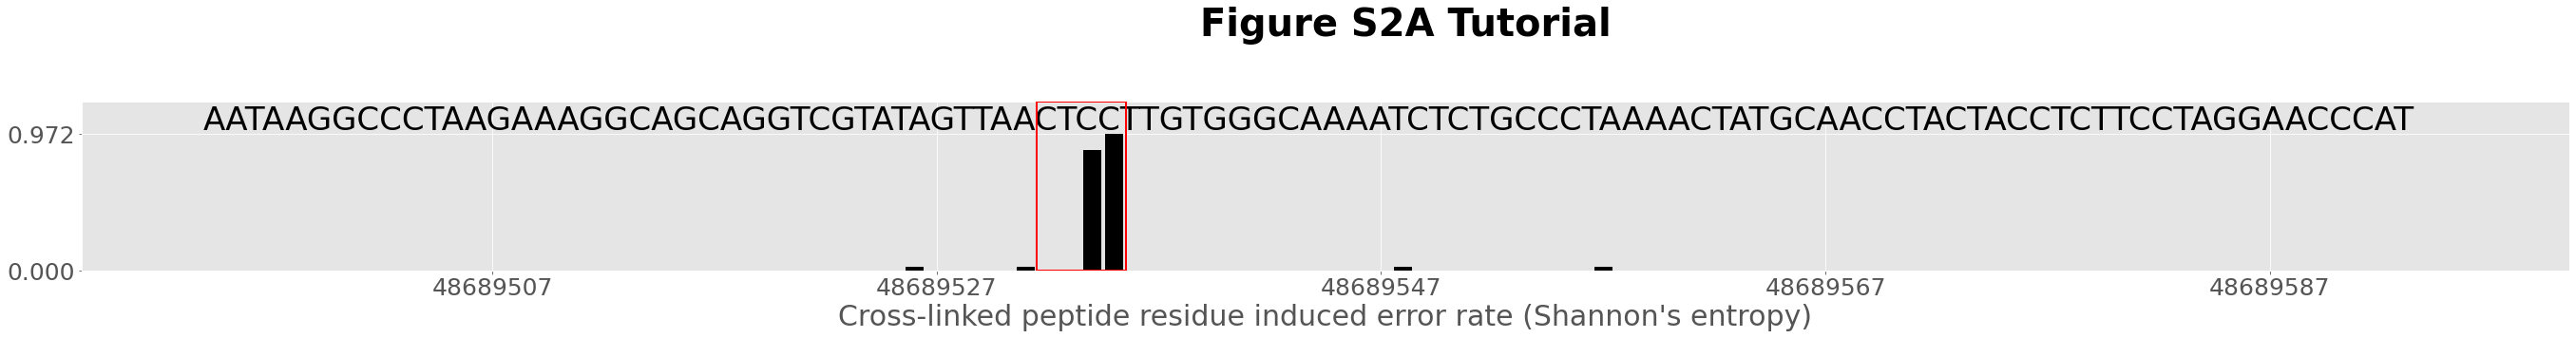

In [239]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1, 1, figsize=(40, 5))

xv1 = list(range(48689487, 48689589))
yv1 = [entropyDic.get(x, 0) for x in xv1]

ax.bar(xv1, yv1, edgecolor='none', color='black', zorder=2)
ax.grid(True, axis = 'y', zorder =1)


ax.set_xlabel("Cross-linked peptide residue induced error rate (Shannon's entropy)", fontsize=30)
xlabels = [48689487, 48689507, 48689527, 48689547, 48689567, 48689587]
ax.set_xticklabels(xlabels, fontsize=25)
#ax.set_xticks([48689488, 48689508, 48689528, 48689548, 48689568, 48689588])
ax.set_yticks([0.0, 0.972])
ax.set_ylim([0, 1.2])
#ax.set_xticks(list(refseq))


ax.text(48689487, 1, refseq, fontsize = 34, zorder=3)
# Create a Rectangle patch
rect = patches.Rectangle((48689524.5, 0), 4, 1.2, linewidth=2, edgecolor='r', facecolor='none', zorder=10)

# Add the patch to the Axes
ax.add_patch(rect)



fig.suptitle('Figure S2A Tutorial\n', fontsize=40, fontweight='bold')
plt.tight_layout()
plt.setp(ax.get_xticklabels(), fontsize=25)
plt.setp(ax.get_yticklabels(), fontsize=25)
plt.savefig('Figure S2A Tutorial.png', dpi = 300)

In [222]:
entropyDic

defaultdict(float,
            {48689487: 0.0,
             48689488: 0.0,
             48689489: 0.0,
             48689490: 0.0,
             48689491: 0.0,
             48689492: 0.0,
             48689493: 0.0,
             48689494: 0.0,
             48689495: 0.0,
             48689496: 0.0,
             48689497: 0.0,
             48689498: 0.0,
             48689499: 0.0,
             48689500: 0.0,
             48689501: 0.0,
             48689502: 0.0,
             48689503: 0.0,
             48689504: 0.0,
             48689505: 0.0,
             48689506: 0.0,
             48689507: 0.0,
             48689508: 0.0,
             48689509: 0.0,
             48689510: 0.0,
             48689511: 0.0,
             48689512: 0.0,
             48689513: 0.0,
             48689514: 0.0,
             48689515: 0.0,
             48689516: 0.0,
             48689517: 0.0,
             48689518: 0.0,
             48689519: 0.027478531192234992,
             48689520: 0.0,
            

In [240]:
with open ('Mirlet7d_entropy', 'w') as file:
    file.write('track type=bedGraph\n')
    for key, value in entropyDic.items():
        start = str(key)
        stop = str(key+1)
        file.write('chr13'+'\t'+start+'\t'+stop+'\t'+str(value)+'\n')
 